In [1]:
import os
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
img = np.asarray(Image.open("./test/test_img5.jpg"))
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [3]:
h, w = gray.shape
circles = cv2.HoughCircles(gray,
                           cv2.HOUGH_GRADIENT,
                           minDist = 100,
                           dp = 1,
                           param1 = 50,
                           param2 = 30,
                           minRadius = 20,
                           maxRadius = max(int(h/2), int(w/2)))

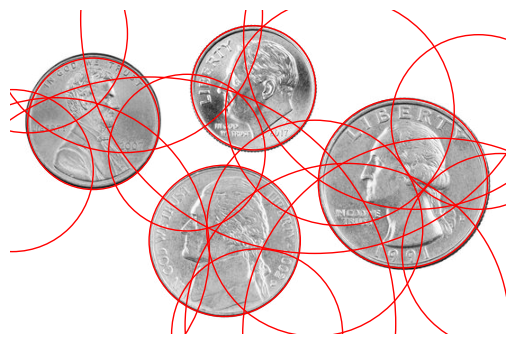

In [4]:
plt.imshow(gray, cmap = 'gray')
plt.axis('off');

ax = plt.gca()
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        draw_circle = plt.Circle((x, y), r, color = 'red', fill = False, linewidth = 1)
        ax.add_patch(draw_circle)

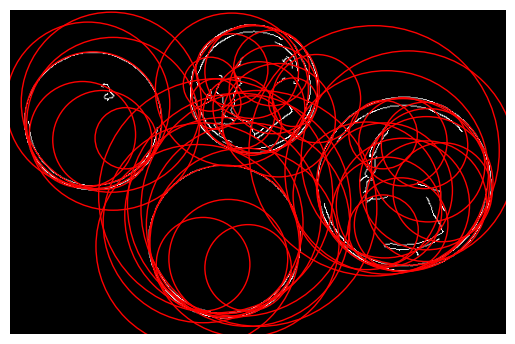

In [5]:
image = cv2.imread("./test/test_img5.jpg", cv2.IMREAD_GRAYSCALE)
image_blurred = cv2.GaussianBlur(image, (9, 9), 2)
edges = cv2.Canny(image_blurred, 50, 150)

h, w = edges.shape
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 
                           dp = 1, 
                           minDist=20, 
                           param1 = 50, 
                           param2 = 30, 
                           minRadius = 20, 
                           maxRadius = max(int(h/2), int(w/2)))

plt.imshow(edges, cmap = 'gray')
plt.axis('off');

ax = plt.gca()
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        draw_circle = plt.Circle((x, y), r, color = 'red', fill = False, linewidth = 1)
        ax.add_patch(draw_circle)

# Watershed

In [46]:
def separate_coins_watershed(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply GaussianBlur to reduce noise and improve watershed segmentation
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)

    # Apply thresholding to obtain a binary image
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Perform morphological operations to clean up the image
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 5)

    # Perform a dilation to fill gaps in between object contours
    sure_bg = cv2.dilate(opening, kernel, iterations = 5)

    # Distance Transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)

    # Add 1 to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the region of unknown with 0
    markers[unknown == 255] = 0

    # Apply Watershed algorithm
    cv2.watershed(image, markers)

    # Draw contours around the separated coins
    image[markers == -1] = [0, 0, 255]  # Mark watershed boundaries in red

    return image

In [53]:
def segment_coins(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)

    # Use adaptive thresholding to obtain a binary image
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Perform morphological operations to clean up the image
    kernel = np.ones((3, 3), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations = 2)

    # Find contours in the binary image
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours around coins
    for contour in contours:
        #cv2.drawContours(image, [contour], 0, (0, 255, 0), 2)

        (x,y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x),int(y))
        radius = int(radius)
        cv2.circle(image, center, radius, (0,255,0), 2)

    return image

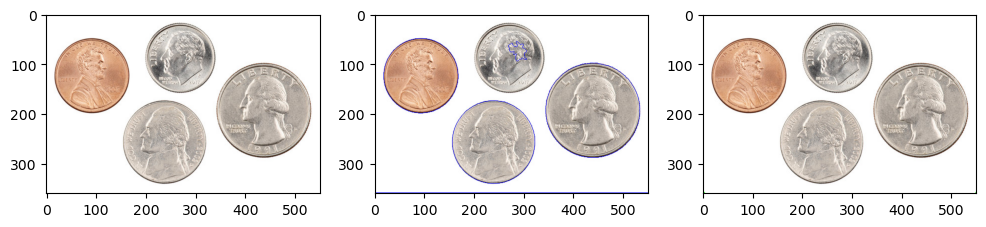

In [54]:
# Read the input image
input_image = cv2.imread("./test/test_img5.jpg")
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Separate touching coins using Watershed Algorithm
result_watershed = separate_coins_watershed(input_image.copy())

# Segment individual coins using thresholding
result_segmented = segment_coins(input_image.copy())

# Display the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 8))
ax1.imshow(input_image)
ax2.imshow(result_watershed)
ax3.imshow(result_segmented)

# Watershed try 2

In [ ]:
# Perform a dilation to fill gaps in between object contours
sure_bg = cv2.dilate(opening, kernel, iterations = 5)

# Distance Transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

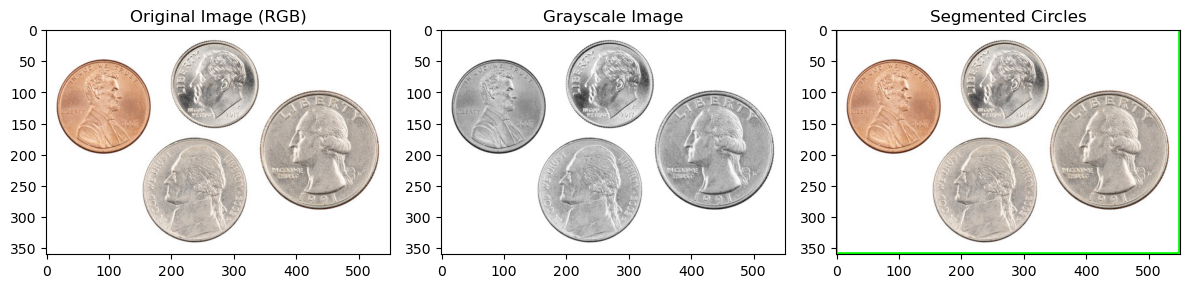

In [60]:
# Read the image in RGB format
image = cv2.imread("./test/test_img5.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the grayscale image
blur = cv2.GaussianBlur(gray, (15, 15), 0)

# Perform edge detection using Canny
edges = cv2.Canny(blur, 50, 30)

# Perform dilation and erosion to close gaps in contours
dilated = cv2.dilate(edges, None, iterations=2)
eroded = cv2.erode(dilated, None, iterations=2)

# Find contours in the eroded image
contours, hierarchy = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty mask for watershed
mask = np.zeros_like(gray)

# Draw the contours on the mask
cv2.drawContours(mask, contours, -1, (255), 2)

# Apply distance transform to the mask
dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)

# Normalize the distance transform
cv2.normalize(dist_transform, dist_transform, 0, 1.0, cv2.NORM_MINMAX)

# Set markers for watershed segmentation
_, markers = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Convert markers to 32-bit single-channel format
markers = markers.astype(np.int32)

# Perform watershed segmentation
markers = cv2.watershed(image, markers)

# Loop over the unique markers and extract each segmented circle
for marker in np.unique(markers):
    if marker == -1:
        continue

    # Create a binary mask for each marker
    circle_mask = np.zeros_like(gray)
    circle_mask[markers == marker] = 255

    # Find contours in the binary mask
    circle_contours, _ = cv2.findContours(circle_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contour on the original image
    cv2.drawContours(image, circle_contours, -1, (0, 255, 0), 2)

# Plot the results using plt.imshow
plt.figure(figsize=(12, 6))

# Original Image in RGB
plt.subplot(131)
plt.imshow(image_rgb)
plt.title('Original Image (RGB)')

# Grayscale Image
plt.subplot(132)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')

# Segmented Circles
plt.subplot(133)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Segmented Circles')

plt.tight_layout()
plt.show()

# Try 3

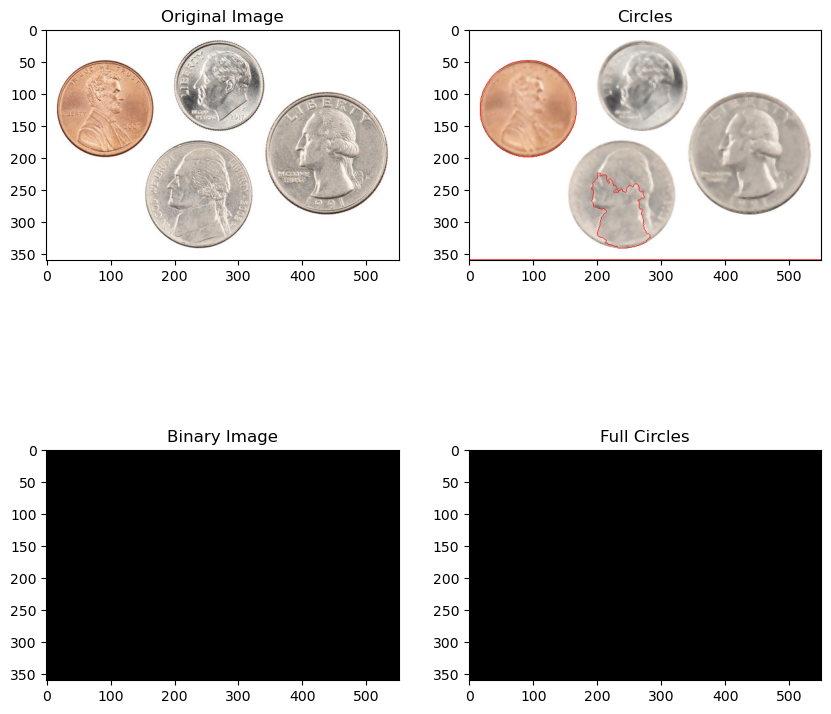

In [61]:
# Load the image
image = cv2.imread("./test/test_img5.jpg")

# Step 1: Apply Median Filter to remove noise
median_filtered = cv2.medianBlur(image, 5)

# Step 2: Use Watershed Algorithm to separate connected circles
gray = cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal using Morphological operations
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed algorithm
cv2.watershed(median_filtered, markers)
median_filtered[markers == -1] = [0, 0, 255]

# Step 3: Threshold segmentation to get a binary image
gray_median = cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_median, 0, 255, cv2.THRESH_BINARY)

# Step 4: Morphology operations to get full circles
kernel_morph = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel_morph, iterations=2)

# Find contours of circles
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Plot RGB images
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(median_filtered, cv2.COLOR_BGR2RGB))
plt.title('Circles')

plt.subplot(2, 2, 3)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')

plt.subplot(2, 2, 4)
plt.imshow(closing, cmap='gray')
plt.title('Full Circles')

plt.show()

# Iterate through each contour and crop the circles
for i, contour in enumerate(contours):
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Crop the circle from the original image
    circle_crop = image[y:y+h, x:x+w]

    # Save or process the cropped circle as needed
    cv2.imwrite(f'circle_{i}.jpg', circle_crop)


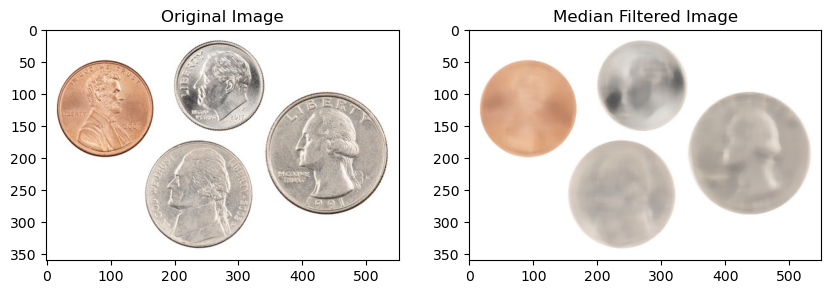

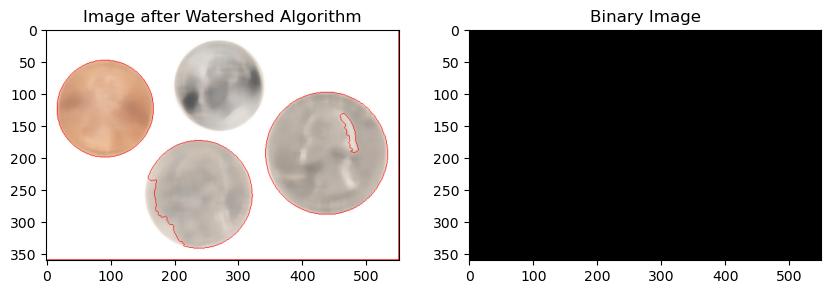

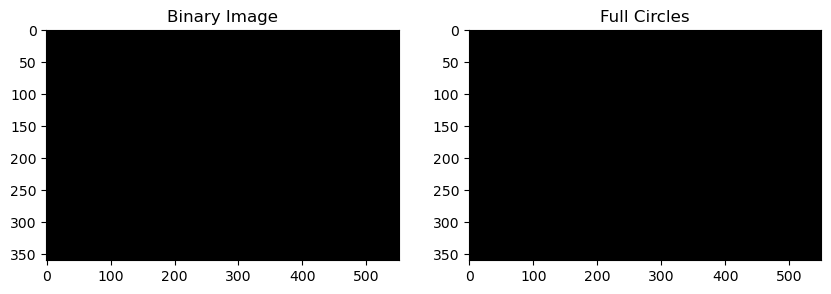

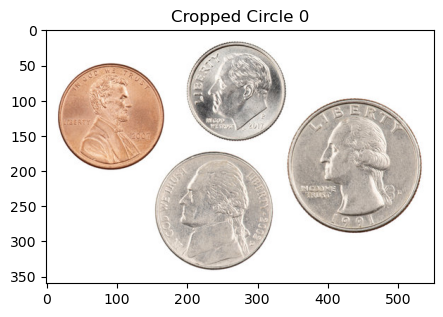

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("./test/test_img5.jpg")

# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

# Step 1: Apply Median Filter to remove noise
median_filtered = cv2.medianBlur(image, 15)

# Plot the image after median filtering
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(median_filtered, cv2.COLOR_BGR2RGB))
plt.title('Median Filtered Image')
plt.show()

# Step 2: Use Watershed Algorithm to separate connected circles
gray = cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal using Morphological operations
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed algorithm
cv2.watershed(median_filtered, markers)
median_filtered[markers == -1] = [0, 0, 255]

# Plot the image after watershed algorithm
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(median_filtered, cv2.COLOR_BGR2RGB))
plt.title('Image after Watershed Algorithm')

# Step 3: Threshold segmentation to get a binary image
gray_median = cv2.cvtColor(median_filtered, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_median, 0, 255, cv2.THRESH_BINARY)

# Plot the binary image
plt.subplot(1, 2, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.show()

# Step 4: Morphology operations to get full circles
kernel_morph = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel_morph, iterations=2)

# Plot the image after morphological operations
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')

plt.subplot(1, 2, 2)
plt.imshow(closing, cmap='gray')
plt.title('Full Circles')
plt.show()

# Find contours of circles
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through each contour and crop the circles
for i, contour in enumerate(contours):
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Crop the circle from the original image
    circle_crop = image[y:y+h, x:x+w]

    # Plot the cropped circle
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(circle_crop, cv2.COLOR_BGR2RGB))
    plt.title(f'Cropped Circle {i}')
    plt.show()

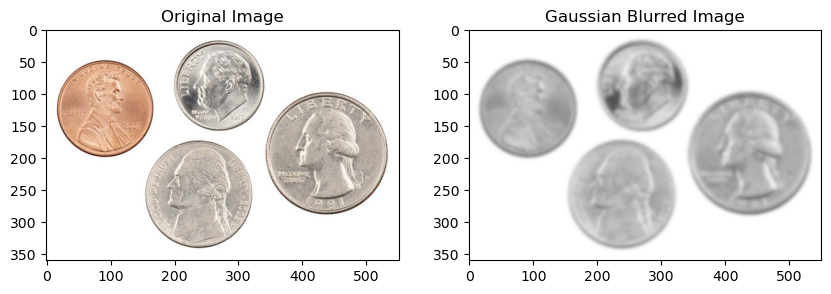

In [71]:
image = cv2.imread("./test/test_img5.jpg")

blur_kernel_size = 15
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(gray_img, (blur_kernel_size, blur_kernel_size), 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

# Plot the image after median filtering
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
plt.title('Gaussian Blurred Image')
plt.show()

Text(0.5, 1.0, 'Image after Watershed Algorithm')

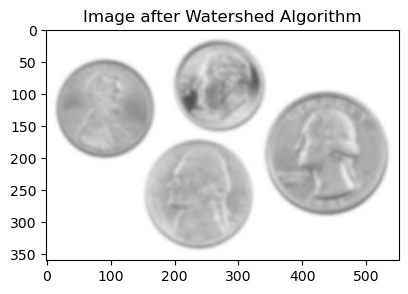

In [77]:
gray = img_blur.copy()
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 5)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed algorithm
cv2.watershed(median_filtered, markers)
median_filtered[markers == -1] = [0, 0, 255]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
plt.title('Image after Watershed Algorithm')